## Predicting Subscription to Minecraft Research Newsletter
DSCI 100: Group Project

<h2> Introduction </h2>

*(background info)*  </p>
*(how was the data collected?)* </p>
*(explain how each chosen variable is a relevant predictor of subscription)* </p>
*(add more to data description - more details?)*

**Players Data Set**: The players.csv data set describes data regarding individual players of the game. It has 196 observations with the 7 following variables: 
|Variable|Data Type|Description|
|---|---|---|
|**experience**|Character|Describes the players' experience with the game as either "Pro", "Veteran", "Regular", or "Amateur"|
|**subscribe**|Logical|Displays "TRUE" if the player is subscribed to the newsletter, and "FALSE" if they are not|
|**hashedEmail**|Character|The unique identification (privacy safe way of displaying email) of the player|
|**played_hours**|Double|Amount of time (hours) players played during all sessions|
|**name**|Character|Players' first name|
|**gender**|Character|Players' gender as "Female", "Male", "Agender", "Two Spirited", "Non-Binary", or "Prefer not to say"|
|**Age**|Double|Players' age in years|



**Summary Statistics:**
|Variable |Min | Max | Mean  | Q1 | Q2 | Q3 |
|---------|----|-----|------|-----|----|----|
|played_hours (hrs)|0.00|223.10|5.85|0.00|0.10|0.60|
|Age (years)|9.00|58.00|21.14|17.00|19.00|22.75|

In [13]:
library(tidyverse)
library(janitor)
library(tidymodels)
library(repr)
library(GGally)

In [14]:
players <- read_csv("players.csv") |>
clean_names() 
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


**Predictive Question:** Can players' experience, game-play time, and age predict whether or not an individual will subscribe to the Minecraft research newsletter in the player dataset?

<h2>Methods and Results</h2>

The goal of predicting players' subscription status using the variables Age, Experience Level, and Hours Played from the "players.csv" dataset can be appropriately performed through KNN Classification. Because the outcome of our predictive question - whether a player will subscribe to the Minecraft Research Newsletter - is binary (TRUE or FALSE), our chosen response variable is categorical. Hence, the KNN classification model is a useful approach to address this question as it makes no assumptions about the distribution of our data, which is helpful given the lack of visible relationships among the three predictors. 

The relationship between age, experience, and played_hours can be examined through a ggpairs plot.

<h4>Relationship Between 3 Chosen Predictors</h4>

Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 2 rows containing missing values”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


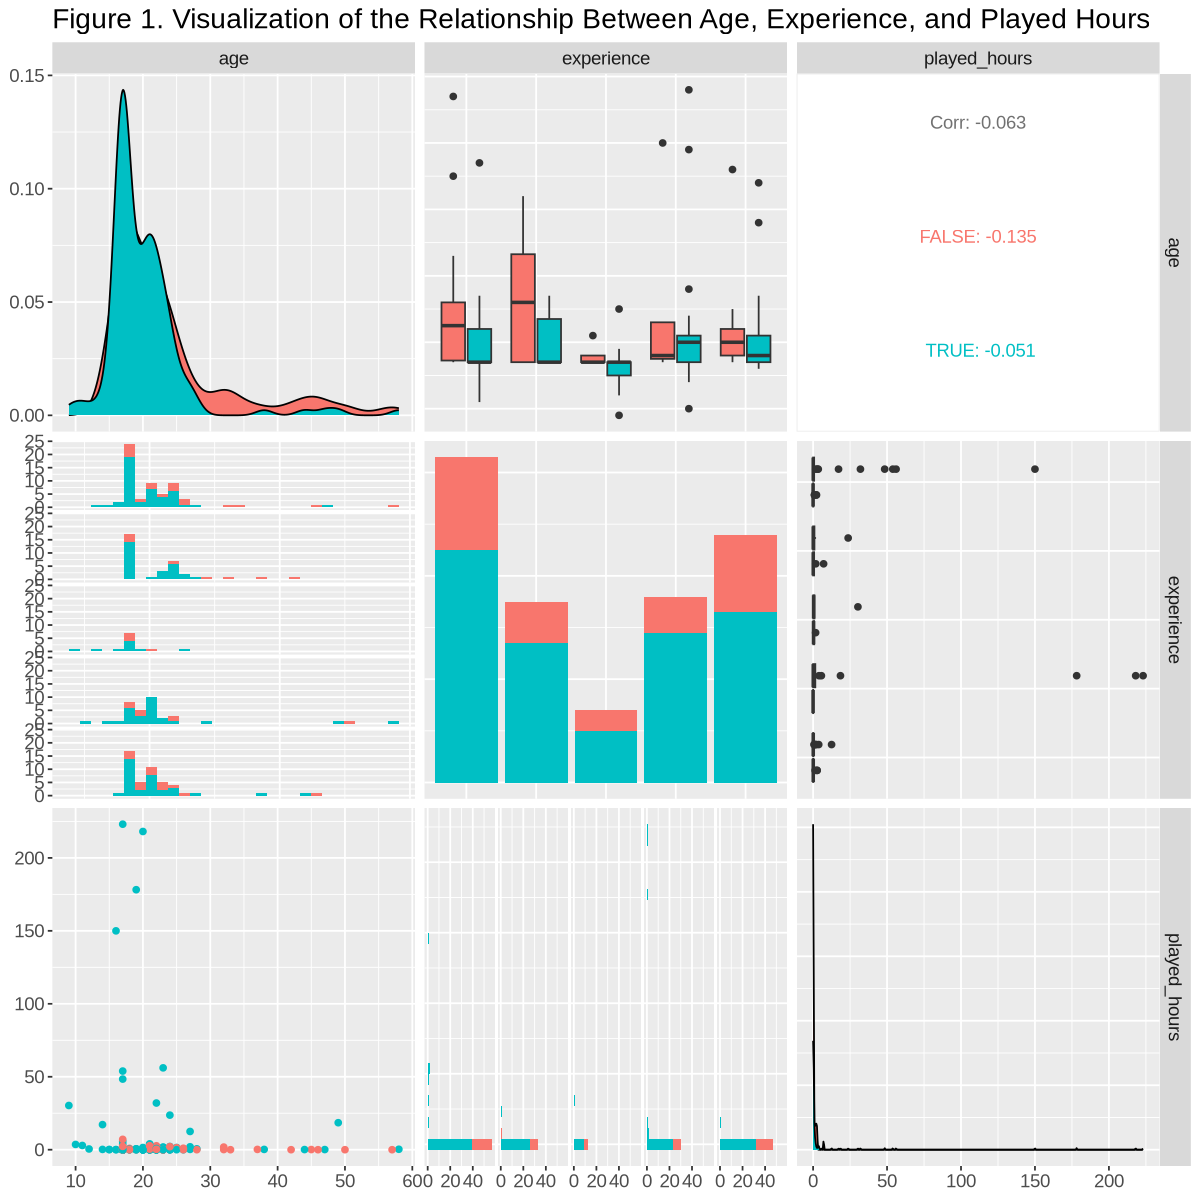

In [15]:
options(repr.plot.width = 10, repr.plot.height = 10)
ggpairs(players, 
        columns = c("age", "experience", "played_hours"), 
        aes(color = subscribe)) +
    ggtitle("Figure 1. Visualization of the Relationship Between Age, Experience, and Played Hours") +
    theme(text = element_text(size = 14))

In [7]:
set.seed(2024)

players <- players |>
    select(subscribe, age, experience, played_hours) |>
    mutate(subscribe = as_factor(subscribe)) |>
    drop_na()  # removes rows with missing values
      

#turn experience into numerical values 
#Fixed the problem so don't think we need this part anymore, just didn't want to delete it incase
#someone put it in for a different reason. 
#players <- players |>
   #mutate(experience = recode(experience,
                     #"Beginner" = 1,
                     #"Amateur"  = 2,
                     #"Regular"  = 3,
                     #"Veteran"  = 4,
                     #"Pro"      = 5))

#splitting data
players_split <- initial_split(players, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

#model k-classification
knn_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

#model recipe
players_recipe <- recipe(subscribe ~ experience + played_hours + age, data = players_train) |>
            step_zv(all_predictors()) |>
            step_scale(all_numeric_predictors()) |>
            step_center(all_numeric_predictors())

#folds
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)



#values of k
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

#workflow results
knn_results <- workflow() |>
                 add_recipe(players_recipe) |>
                 add_model(knn_tune_spec) |>
                 tune_grid(resamples = players_vfold, grid = k_vals) |>
                 collect_metrics()

#determine the accuracy 
accuracies <- knn_results |>
                  filter(.metric == 'accuracy') |>
                  select(neighbors, mean)

#determines best K value
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 7

In [10]:
#model k-classification
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
            set_engine("kknn") |>
            set_mode("classification")

#knn fit
players_fit <- workflow() |>
            add_recipe(players_recipe) |>
            add_model(players_spec) |>
            fit(data = players_train)
                                

<h2>Discussion</h2>